In [1]:
import pickle
import math
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt

#### Part 1: Expected Signifcance
The purpose of this lab is to search for the Higgs boson in simulated LHC data, and then use machine learning to optimize event selections to enhance discovery sensitivity. The ideal event selections will be used on selected psuedo-experimental data.

In [2]:
qcd_file = open("qcd_100000_pt_1000_1200.pkl", 'rb')
qcd_d = pickle.load(qcd_file)

higgs_file = open("higgs_100000_pt_1000_1200.pkl", 'rb')
higgs_d = pickle.load(higgs_file)

features = [key for key in qcd_d.keys()]
print(features)

['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR']


According to the Standard Model, the Higgs field interacts with particles to give them mass. The Higgs boson is the quantum particle which interacts with the Higgs field. Using this understanding that mass is a defining feature of the Higgs particle, we can examine the mass of a a jet in order to discriminate between jets containing Higgs particles and those containing a variety of other quantum chromodynamic (QCD) particles.

The goal of this analysis is to confirm the existence of the Higgs boson with maximum confidence, as direct observation of the particle is obscured by QCD noise.

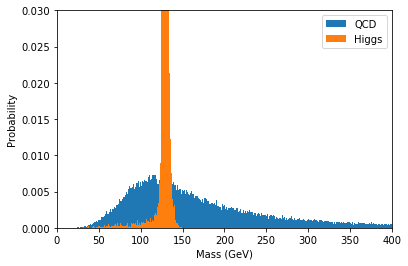

In [3]:
qcd_hist = plt.hist(qcd_d.mass, density=True, bins=1000, label='QCD')
higgs_hist = plt.hist(higgs_d.mass, density=True, bins=1000, label='Higgs')
plt.ylim(0,0.03)
plt.xlim(0,400)
plt.ylabel('Probability')
plt.xlabel('Mass (GeV)')
plt.legend()
plt.show()

The hisogram above compares the mass of a QCD jet (blue) and a Higgs jet (orange). By visual inspection, we can see that the histograms are very different, so mass would make for a good discriminatory feature. While Higgs particles may have a similar mass to QCD particles on average, Higgs particles have a much smaller standard deviation of mass, and appear to usually have a mass between 120 and 140 GeV.

We assume that the mass distribution for the QCD background and Higgs signal are both Poisson with expected yields of $N_{QCD} = 2000$ and $N_{Higgs} = 50$. Each distribution has $\lambda = N$, where N is its expected yield. The null hypothesis suggests that there is no Higgs particle, so the expected background would be $N_{QCD}$. What is the significance of having recorded $N_{QCD}+N_{Higgs}$ particles?

In [4]:
evh = 50
evq = 2000
evtot = evq + evh
theoreticalsig = stats.norm.isf(stats.poisson.sf(evtot,evq))
print('Significance: ', theoreticalsig)

Significance:  1.1282230087754423


For a poisson distribution with large $\lambda$ we can approximate with a gaussian distribituted variable with mean $\lambda$ and standard deviation $\sqrt{\lambda}$

$$S = \Phi^{-1}(1-p)$$
The p-value of the background only given an event $x$ is
$$p = 1 - \Phi({\frac{x-\mu}{\sigma}})$$
Where $\mu = \lambda_{QCD}$ and $\sigma = \sqrt{\lambda_{QCD}}$,
$$p = 1 - \Phi({\frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}})$$
Setting up for our equation for significance,
$$1-p = \Phi({\frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}})$$
$$\Phi^{-1}(1-p) = \frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}$$
Finally our value for significance,
$$S_x = \frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}$$
The average of X is $\lambda_{QCD}+\lambda_{Higgs}$
$$S_{avg} = \frac{\lambda_{Higgs}}{\sqrt{\lambda_{QCD}}}$$

By this formula, the average significance of the distribution X (the sum of the Higgs and QCD distributions) is $\frac{N_{Higgs}}{\sqrt{N_{QCD}}}$.

In [5]:
observed_sig = evh/math.sqrt(evq)
print("Significance: ", observed_sig)

Significance:  1.118033988749895


The difference between our significance calculation using Poisson statistics and the analytic formula we derived was almost negligible at ~0.01 sigma.  


### Part 2: Optimize Event Selection
Now, using our analytic formula, we find subsets of the data with the highest expected significance. First we visualize the data with a scatter plot,

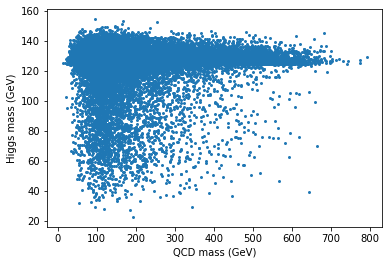

In [6]:
x = np.linspace(min(qcd_d.mass), max(qcd_d.mass), len(qcd_d.mass))
plt.scatter(qcd_d.mass, higgs_d.mass, marker='.', linewidth=0.0001)
plt.xlabel('QCD mass (GeV)')
plt.ylabel('Higgs mass (GeV)')
plt.show()

The plot above shows a clear seperation between the Higgs masses and QCD masses. It seems that most of the Higgs data is between 120 and 140 GeV, while most of the QCD data would be excluded with these cutoffs. We can further optimize our range by using a random grid search, where every point in the Higgs data set becomes the corner of a cut and the expected significance is calculated using the analytical formula from part 1. The range resulting in the highest expected significance is recorded.

In [7]:
print(len(higgs_d.mass))

100000


In [8]:
best_sig_gt = 0
best_sig_lt = 0
best_cut_mass = [0,0]
size = len(higgs_d.mass)
for m in higgs_d.mass:
    higgs_gt_m = len(higgs_d.mass[higgs_d.mass>m])
    qcd_gt_m = len(qcd_d.mass[qcd_d.mass>m])
    higgs_lt_m = size - higgs_gt_m
    qcd_lt_m = size-qcd_gt_m
    #Cut all less than m; find significance
    N_higgs = evh*higgs_gt_m/size
    N_qcd = evq*qcd_gt_m/size
    expected_sig = N_higgs / math.sqrt(N_qcd)
    if(expected_sig > best_sig_gt):
        best_sig_gt = expected_sig
        best_cut_mass[0] = m
    #Cut all greater than m; find significance
    N_higgs = evh*higgs_lt_m/size
    N_qcd = evq*qcd_lt_m/size
    expected_sig = N_higgs / math.sqrt(N_qcd)
    if(expected_sig > best_sig_lt):
        best_sig_lt = expected_sig
        best_cut_mass[1] = m
        
print(f'Best mass cut range: ({best_cut_mass[0]:.2f}, {best_cut_mass[1]:.2f})')

Best mass cut range: (122.45, 137.22)


In [9]:
higgs_mask = higgs_d.mass.between(best_cut_mass[0],best_cut_mass[1])
qcd_mask = qcd_d.mass.between(best_cut_mass[0],best_cut_mass[1])
N_higgs = evh*len(higgs_d.mass[higgs_mask])/size
N_qcd = evq*len(qcd_d.mass[qcd_mask])/size
expected_sig = N_higgs / math.sqrt(N_qcd)
print(f'N_Higgs: {N_higgs:.0f}, N_QCD: {N_qcd:.0f}')
print('Higgs jets: ', len(higgs_d.mass[higgs_mask]))
print('QCD jets: ',len(qcd_d.mass[qcd_mask]))
print(f'Expected significance in best mass cut range: {expected_sig:.2f}')
print(f'Probability of observation given null hypothesis: {stats.norm.sf(expected_sig)}')

N_Higgs: 47, N_QCD: 187
Higgs jets:  93233
QCD jets:  9334
Expected significance in best mass cut range: 3.41
Probability of observation given null hypothesis: 0.0003226102533907361


Using random grid search starting from each side of the mass distribution, we find that cutting all mass data outside the range 122.5 to 137.2 maximizes expected significance using the formula $S = \frac{\lambda_{Higgs}}{\sqrt{\lambda_{QCD}}}$. The range contains the maximum signal to noise ratio in the dataset. If the null hypothesis that no Higgs particles exist is true, then the expected significance of this measurement would be 3.41 sigma.

Besides mass, there are many other discriminating features that can differentiate between a Higgs particle and a QCD particle. Below are stacked histograms for the rest of the features without mass cuts, where the Higgs data is in orange and QCD background in blue.

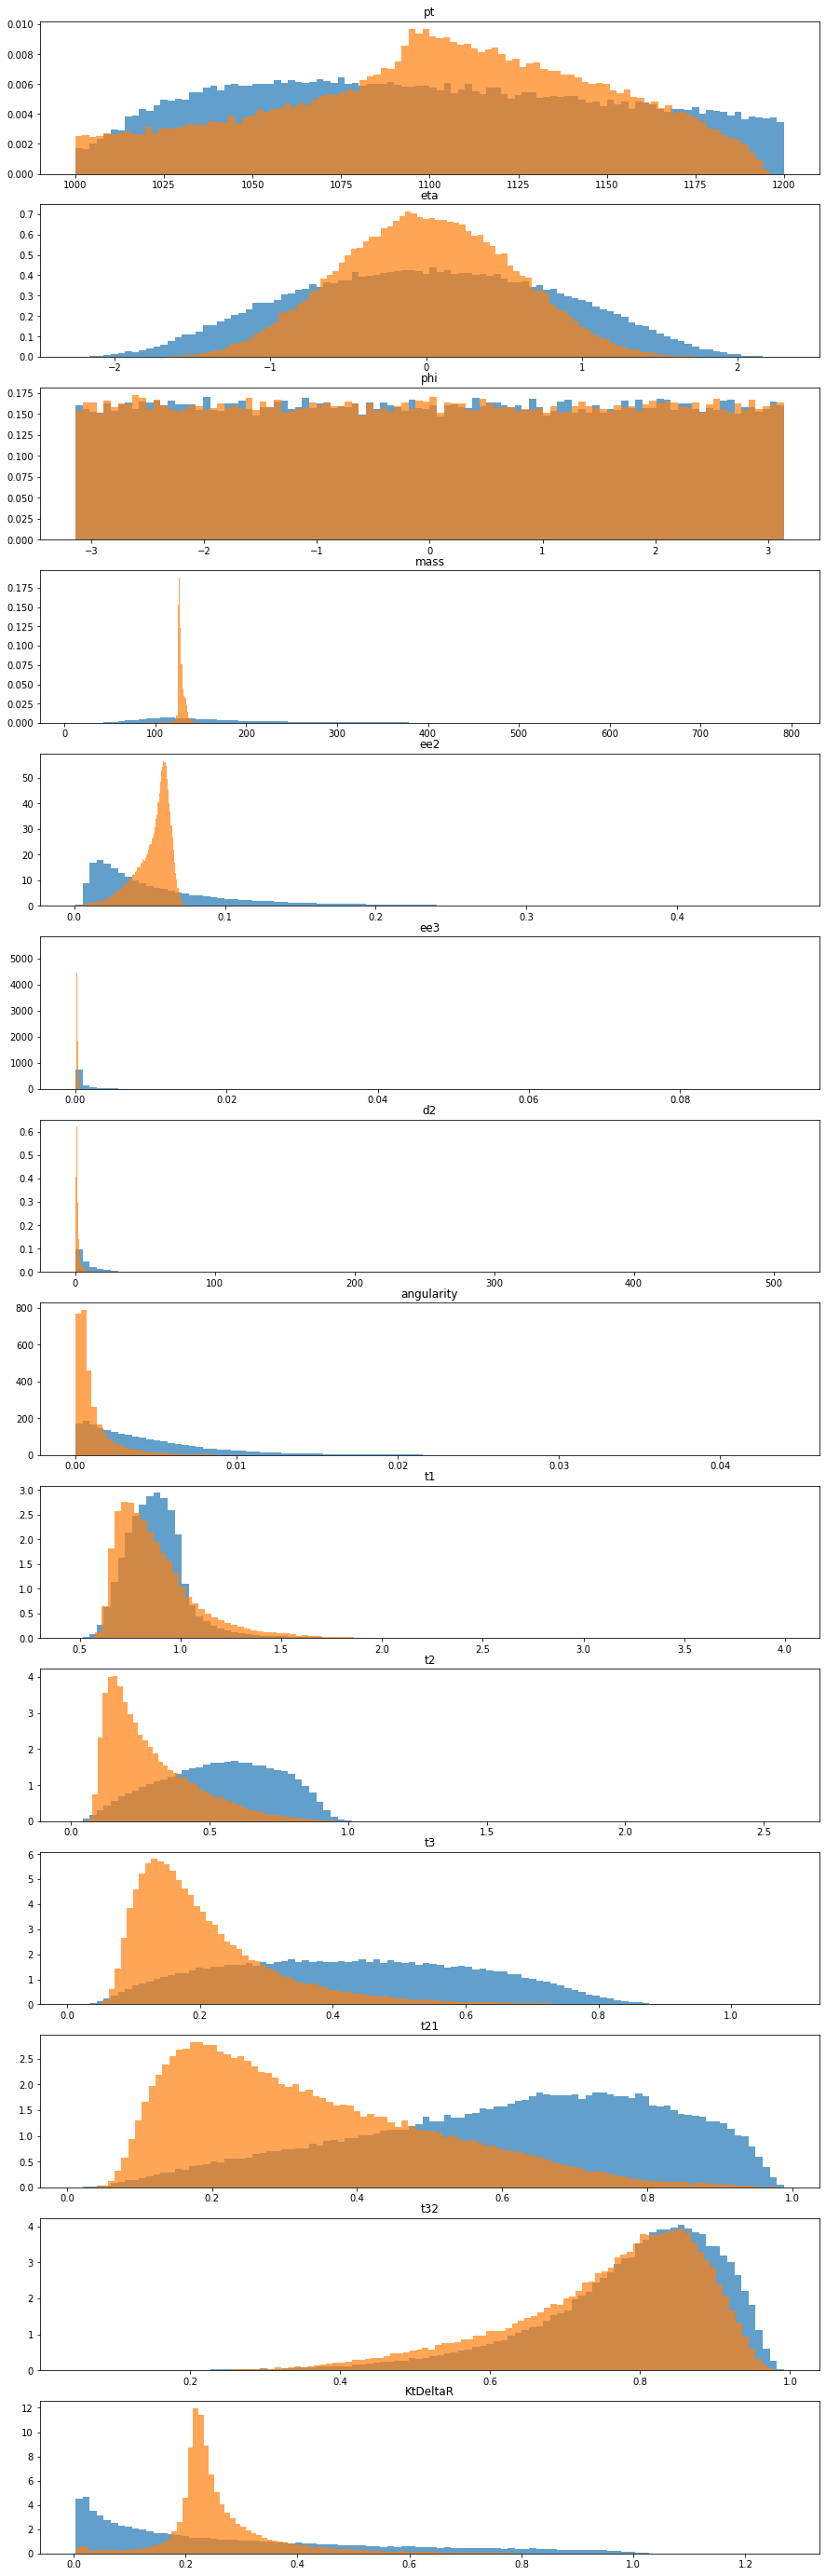

In [10]:
fig, ax_arr = plt.subplots(len(qcd_d.keys()),1, figsize=(15,50))
index = 0
for key in qcd_d.keys():
    ax_arr[index].hist(qcd_d.get(key), bins=100, density=True, alpha=0.7)
    ax_arr[index].title.set_text(key)
    ax_arr[index].hist(higgs_d.get(key), bins=100, density=True, alpha = 0.7)
    ax_arr[index].title.set_text(key)
    index += 1

Now, using the optimal mass cuts to reduce the data set, we plot all the features again:

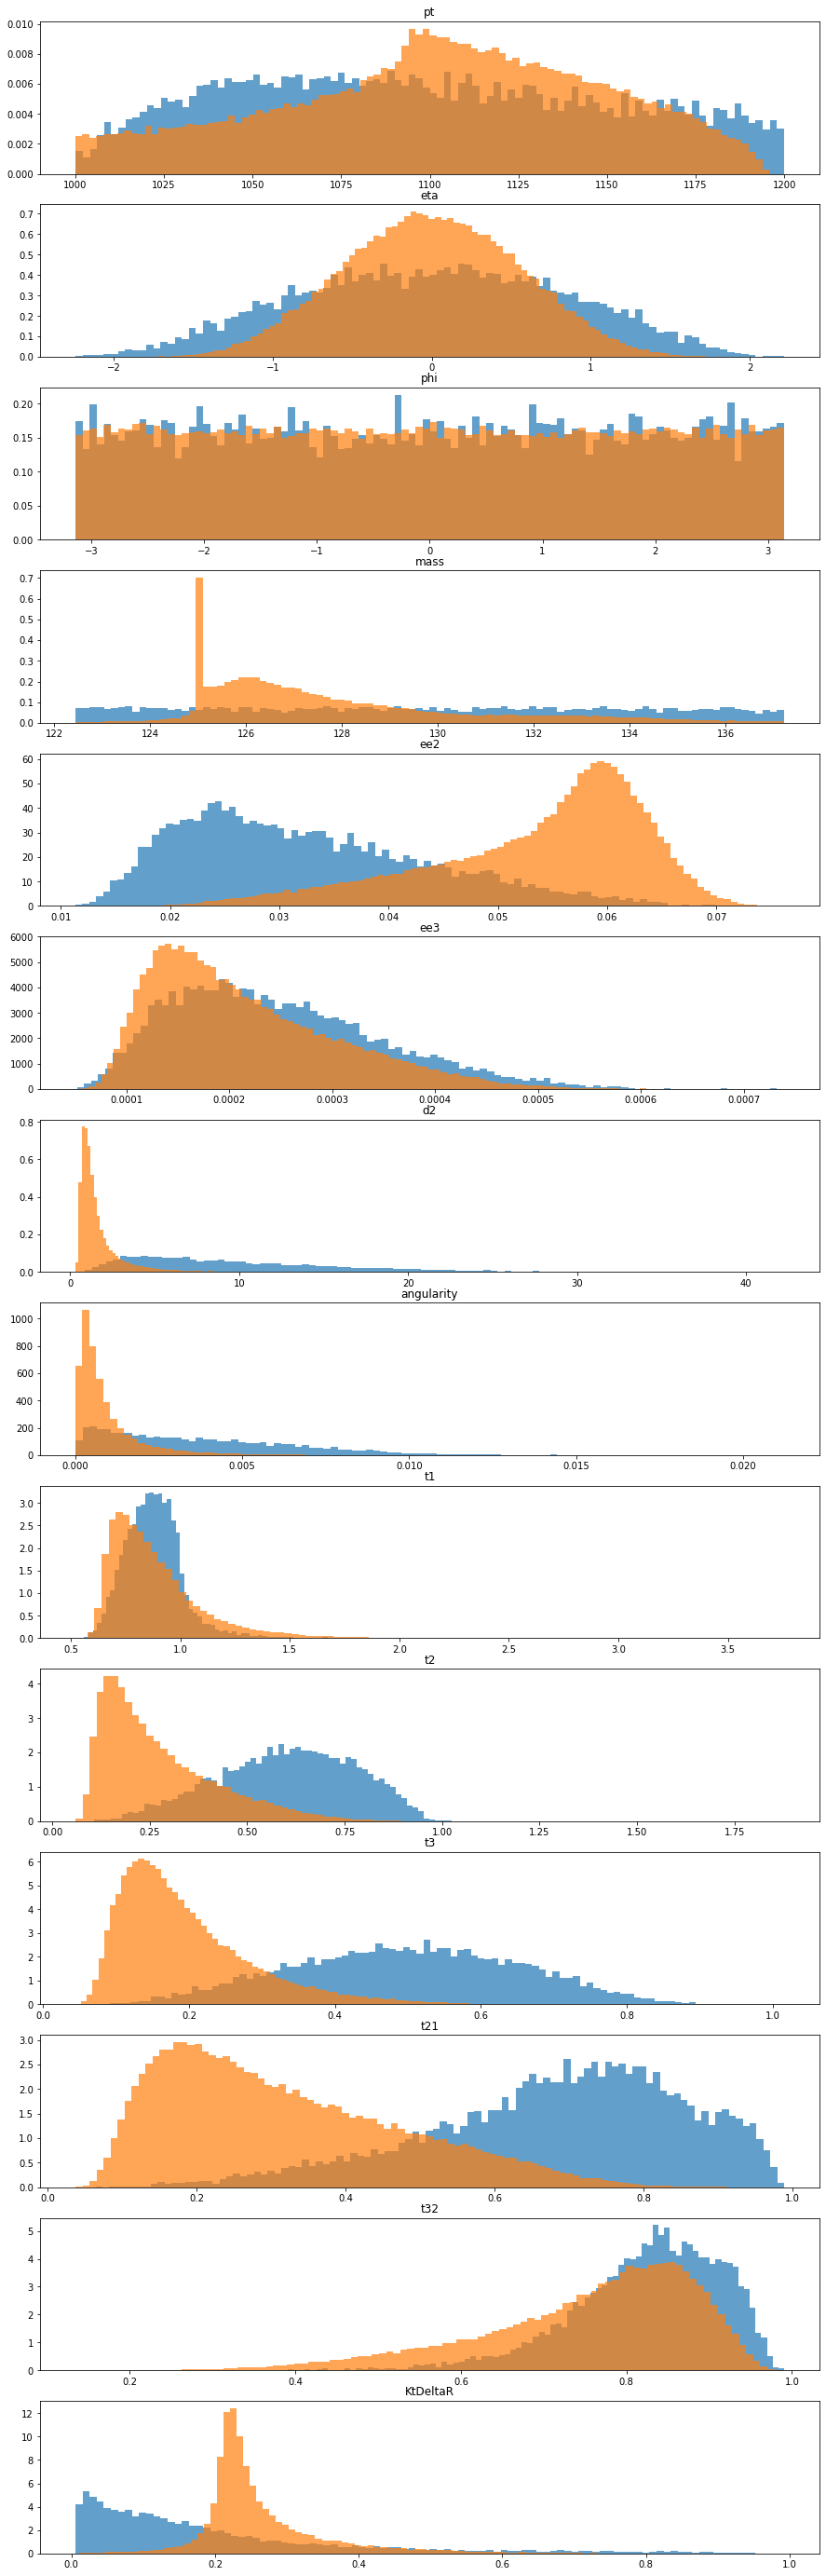

In [11]:
higgs_cut = higgs_d[higgs_d.mass.between(best_cut_mass[0],best_cut_mass[1])]
qcd_cut = qcd_d[qcd_d.mass.between(best_cut_mass[0],best_cut_mass[1])]
fig, ax_arr = plt.subplots(len(qcd_cut.keys()),1, figsize=(15,50))
index = 0
for key in qcd_d.keys():
    ax_arr[index].hist(qcd_cut.get(key), bins=100, density=True, alpha = 0.7)
    ax_arr[index].title.set_text(key)
    ax_arr[index].hist(higgs_cut.get(key), bins=100, density=True, alpha=0.7)
    ax_arr[index].title.set_text(key)
    index += 1

With visual inspection, we see that ee2, d2, and KtDeltaR are good discrimnators, and that the mass histogram for both datasets changes significantly with the mass cut.

In [12]:
corr_table = qcd_d.corr()
a = (corr_table-np.eye(len(corr_table))).max()
b = (corr_table-np.eye(len(corr_table))).idxmax()
pd.DataFrame([a,b]).T

,0,1
pt,0.0954613,mass
eta,0.00178366,phi
phi,0.00284771,t32
mass,0.959965,ee2
ee2,0.959965,mass
ee3,0.844699,ee2
d2,0.622112,t3
angularity,0.529638,mass
t1,0.326725,t2
t2,0.93664,t3


As we can see from the table above, ee2 and mass are highly correlated, while d2 and KtDeltaR are more independant. We choose to analyze d2 and find the optimal cuts via random grid search.

In [13]:
best_sig_gt = 0
best_sig_lt = 0
best_cut_d2 = [0,0]
size = len(higgs_d.d2)
for d in higgs_cut.d2:
    higgs_gt_d = len(higgs_d.d2[higgs_d.d2>d])
    qcd_gt_d = len(qcd_d.d2[qcd_d.d2>d])
    higgs_lt_d = size - higgs_gt_d
    qcd_lt_d = size-qcd_gt_d
    #Cut all less than d; find significance
    N_higgs = evh*higgs_gt_d/size
    N_qcd = evq*qcd_gt_d/size
    expected_sig = N_higgs / math.sqrt(N_qcd)
    if(expected_sig > best_sig_gt):
        best_sig_gt = expected_sig
        best_cut_d2[0] = d
    #Cut all greater than d; find significance
    N_higgs = evh*higgs_lt_d/size
    N_qcd = evq*qcd_lt_d/size
    expected_sig = N_higgs / math.sqrt(N_qcd)
    if(expected_sig > best_sig_lt):
        best_sig_lt = expected_sig
        best_cut_d2[1] = d
        
print(f'Best d2 cut range: ({best_cut_d2[0]:.2f}, {best_cut_d2[1]:.2f})')

Best d2 cut range: (0.36, 1.42)


In [14]:
higgs_mask = higgs_d.d2.between(best_cut_d2[0],best_cut_d2[1]) & higgs_d.mass.between(best_cut_mass[0], best_cut_mass[1])
qcd_mask = qcd_d.d2.between(best_cut_d2[0],best_cut_d2[1]) & qcd_d.mass.between(best_cut_mass[0], best_cut_mass[1])
N_higgs = evh*len(higgs_d.mass[higgs_mask])/size
N_qcd = evq*len(qcd_d.mass[qcd_mask])/size
expected_sig = N_higgs / math.sqrt(N_qcd)
#expected_sig = stats.norm.isf(stats.poisson.sf(N_higgs+N_qcd, N_qcd))
print(f'N_Higgs: {N_higgs:.0f}, N_QCD: {N_qcd:.0f}')
print('Higgs jets: ', len(higgs_d.mass[higgs_mask]))
print('QCD jets: ',len(qcd_d.mass[qcd_mask]))
print(f'Expected significance in best mass, d2 cut range: {expected_sig:.2f}')
print(f'Probability of observation given null hypothesis: {stats.norm.sf(expected_sig)}')

N_Higgs: 28, N_QCD: 1
Higgs jets:  56130
QCD jets:  59
Expected significance in best mass, d2 cut range: 25.84
Probability of observation given null hypothesis: 1.7511252360831353e-147


In the above example, the optimal cuts for d2 were found seperately from the optimal cuts for mass. When using both mass and d2 cuts for event selection, the expected significance reaches 26 sigma using our analytical formula $S = \frac{N_{Higgs}}{\sqrt{N_{QCD}}}$. If our null hypothesis was true that no Higgs particles existed, this observation of 29 particles in this range with an expected count of 1 would have a significance of 26 sigma, or a one in 4.0e+148 chance using our analytical formula; using actual poisson statistics, it is nearer to 1.0e-30, however with such small sample sizes it seems more fitting to use the analytical formula, as the accuracy was already established when looking at the entire data set.

Below are the histograms of the Higgs and QCD data sets after our optimal mass and d2 cuts. There are only ~60 data points comprising the QCD background with these optimal cuts, so the QCD histograms are sparse and unreliable.

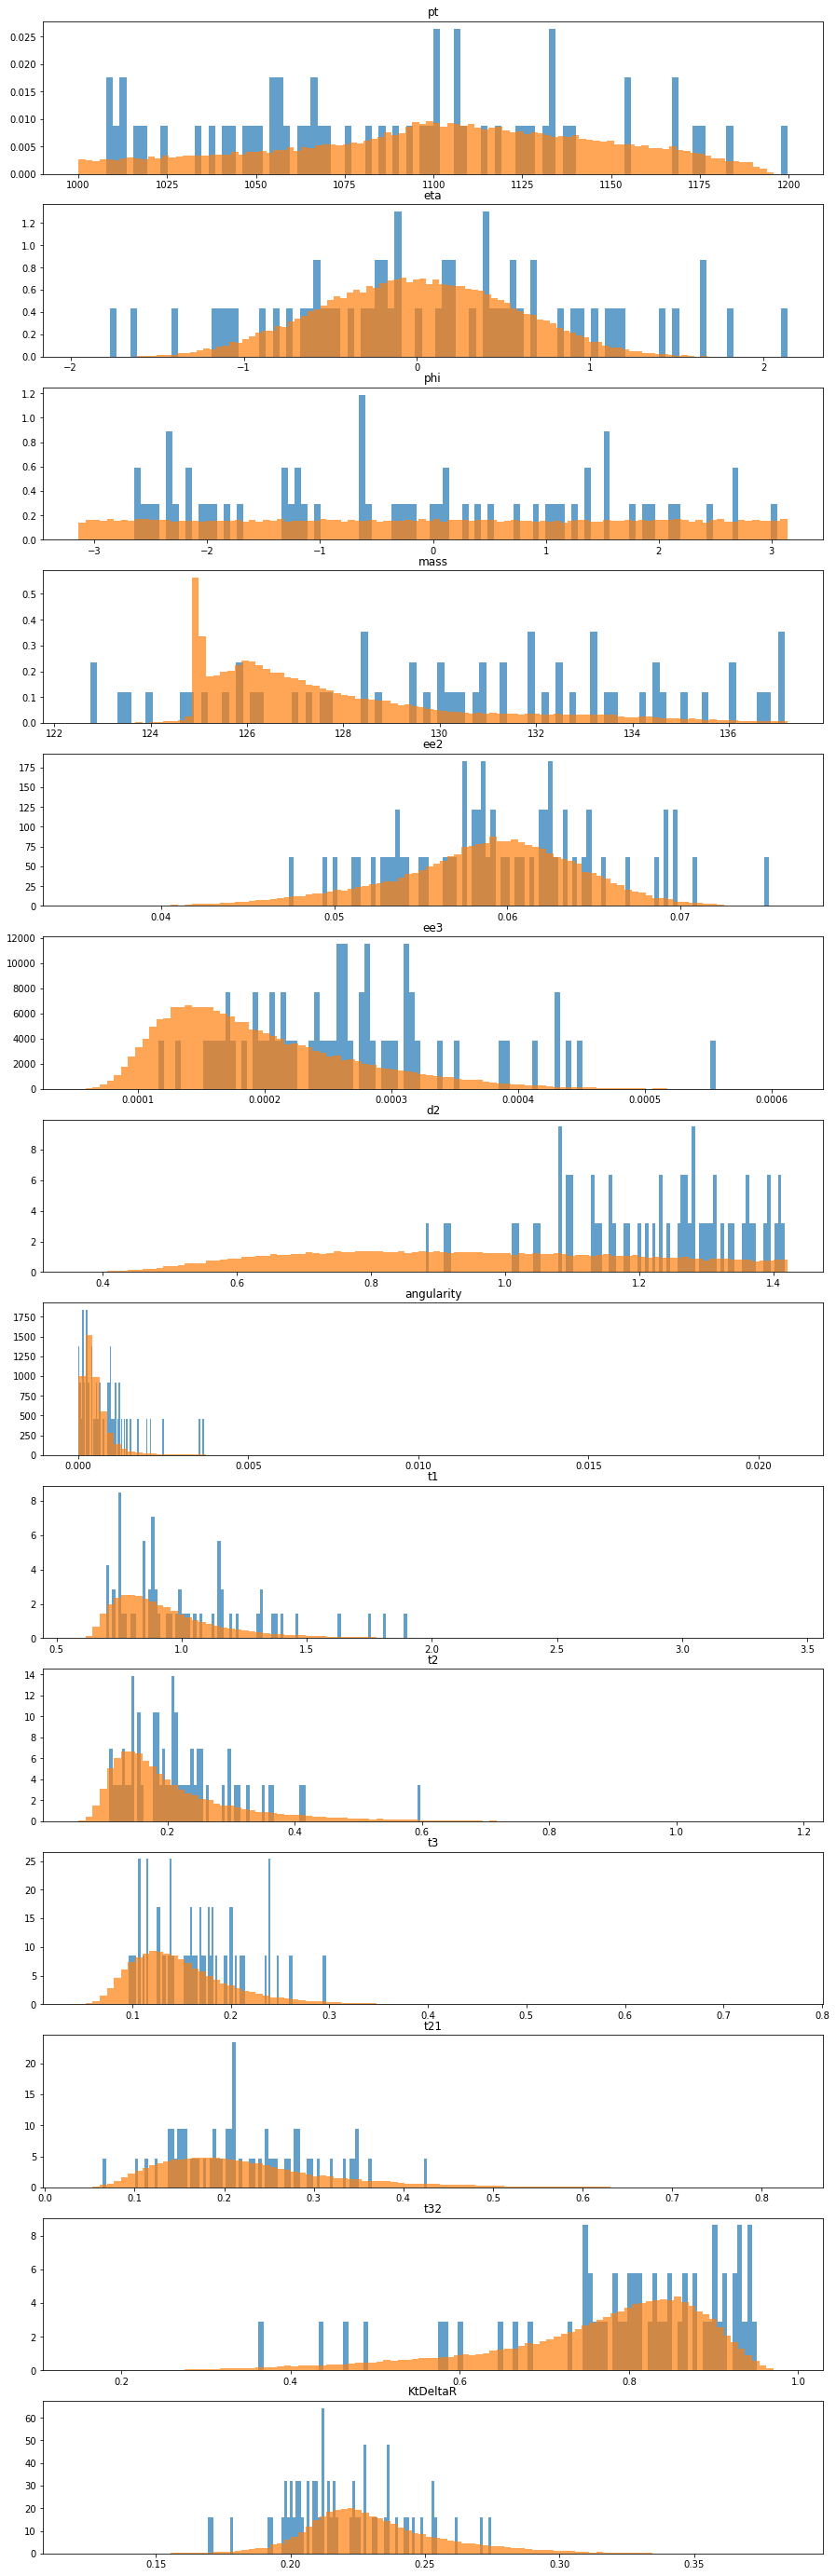

In [15]:
higgs_cut = higgs_d[higgs_mask]
qcd_cut = qcd_d[qcd_mask]
fig, ax_arr = plt.subplots(len(qcd_cut.keys()),1, figsize=(15,50))
index = 0
for key in qcd_d.keys():
    ax_arr[index].hist(qcd_cut.get(key), bins=100, density=True, alpha = 0.7)
    ax_arr[index].title.set_text(key)
    ax_arr[index].hist(higgs_cut.get(key), bins=100, density=True, alpha = 0.7)
    ax_arr[index].title.set_text(key)
    index += 1

The important takeaway from this plot is the transformation which occured to the mass and d2 histograms due to the mass and d2 cuts. Below, the cut region is visualized with scatterplots of the mass and d2 features for both the Higgs data set and the QCD data set.

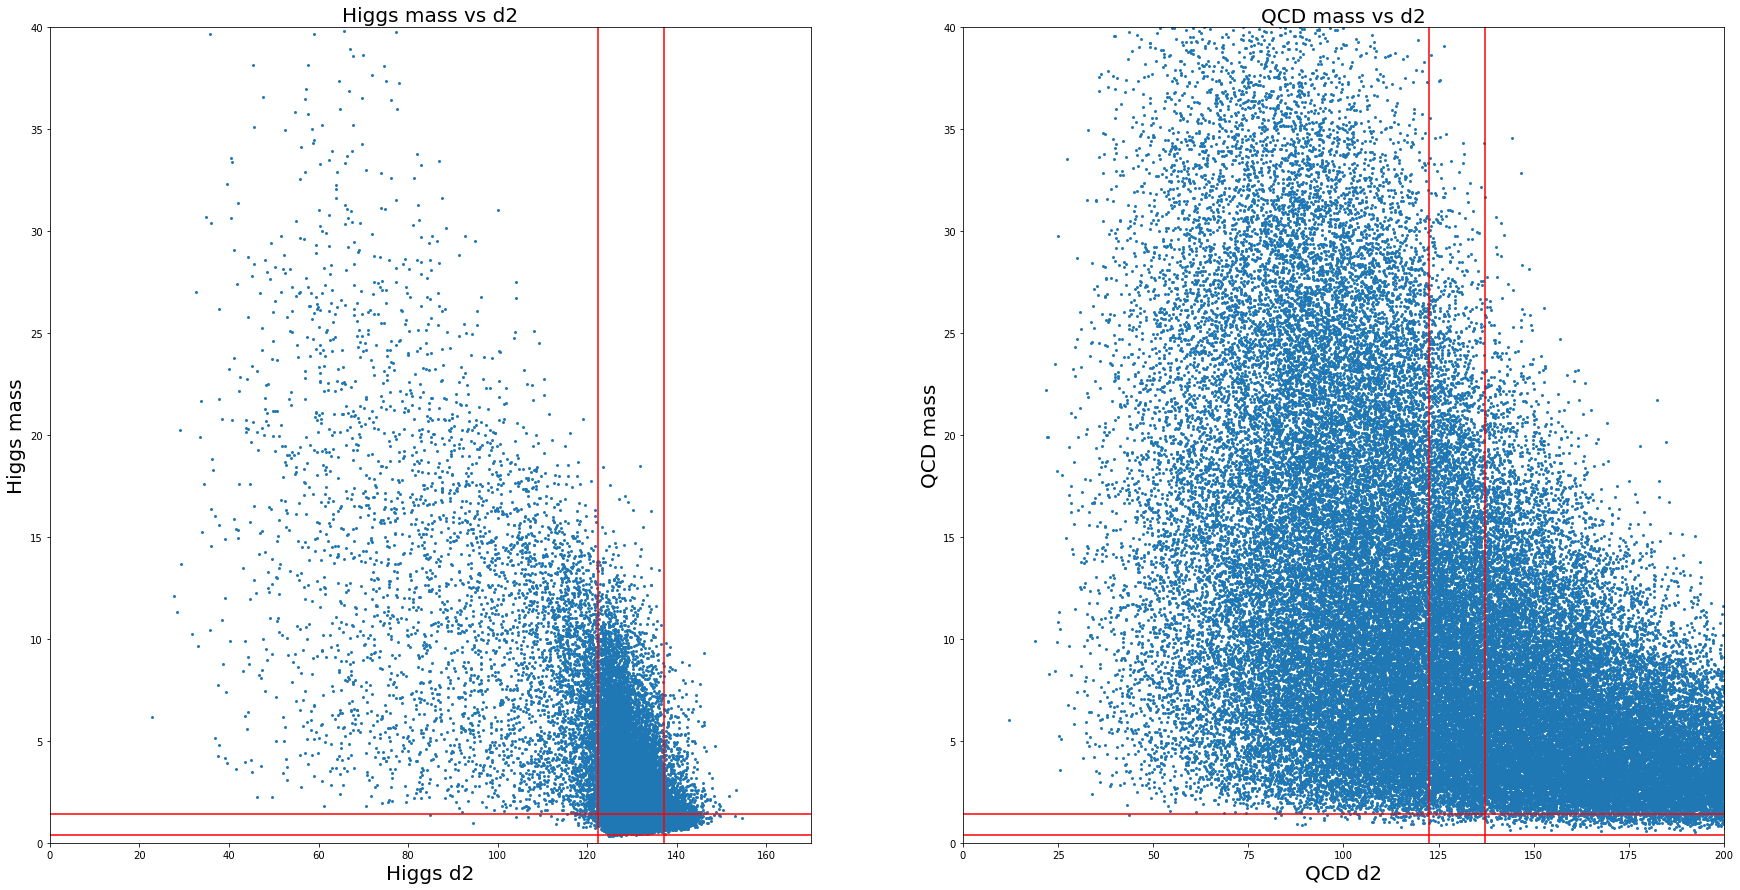

In [16]:
fig, ax = plt.subplots(1,2,figsize=(30,15))
ax[0].scatter(higgs_d.mass, higgs_d.d2, marker='.', linewidth=0.0001)
x = np.linspace(min(qcd_d.mass), max(qcd_d.mass), len(qcd_d.mass))
ax[0].vlines(best_cut_mass[0],0,150, colors='r')
ax[0].vlines(best_cut_mass[1],0,150, colors='r')
ax[0].hlines(best_cut_d2[0],0,700, colors='r')
ax[0].hlines(best_cut_d2[1],0,700, colors='r')
ax[0].set_xlim(0,170)
ax[0].set_ylim(0, 40)
ax[0].set_title('Higgs mass vs d2', size=20)
ax[0].set_ylabel('Higgs mass', fontsize=20)
ax[0].set_xlabel('Higgs d2', fontsize=20)
x = np.linspace(min(higgs_d.mass), max(higgs_d.mass), len(higgs_d.mass))
ax[1].scatter(qcd_d.mass, qcd_d.d2, marker='.', linewidth=0.0001)
ax[1].vlines(best_cut_mass[0],0,50, colors='r')
ax[1].vlines(best_cut_mass[1],0,50, colors='r')
ax[1].hlines(best_cut_d2[0],0,200, colors='r')
ax[1].hlines(best_cut_d2[1],0,200, colors='r')
ax[1].set_xlim(0,200)
ax[1].set_ylim(0,40)
ax[1].set_title('QCD mass vs d2', size=20)
ax[1].set_ylabel('QCD mass', fontsize=20)
ax[1].set_xlabel('QCD d2', fontsize=20)
plt.show()

The red lines represent the cuts on mass and d2. The Higgs dataset has a large subset enclosed by the cuts, while the QCD background is mostly excluded. The area enclosed by these cuts contains the maximum signal to noise ratio of these two features.

A different approach to discriminating between Higgs and QCD events is to create a classifier to discern whether an event comes from the Higgs data set or the QCD data set. It will use the two features we've selected, mass and d2.

In [17]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
#from sklearn.model_selection import cross_val_score

X = higgs_d.append(qcd_d)
y = np.append(np.ones((len(higgs_d),1), dtype=int),
              np.zeros((len(qcd_d),1),dtype=int))

In [18]:
#Using only two features, mass and d2 (the same as analyzed above)
X_new = np.array([X.mass, X.d2]).T

In [19]:
#X_scaled = preprocessing.StandardScaler().fit_transform(X_new)
X_train, X_test, y_train, y_test = train_test_split(X_new,y, test_size=0.6)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
clf = svm.SVC(kernel='poly', degree=3, gamma='scale', probability=True)
clf.fit(X_train_scaled,y_train)
clf.score(X_test_scaled, y_test)

0.8903

Using only the features mass and d2, a support vector classifier with a polynomial kernel of degree 3 is trained on a randomly shuffled 80% of the 200k events (100k Higgs and 100k QCD). With only two features this classifier achieves ~89% accuracy at determining whether or not a given event comes from the higgs data set or the QCD data set. This could be increased using additional features, at the cost of computational complexity.

Below is a plot of the classification boundaries. The first plot is the probability of classification as a higgs event (in blue/purple) vs classification as a QCD event (yellow) based on the two features mass and d2 by the polynomial support vector classifier. To the right is a scatterplot of Higgs and QCD mass vs d2, with the Higgs events in brown and the QCD events in light blue.

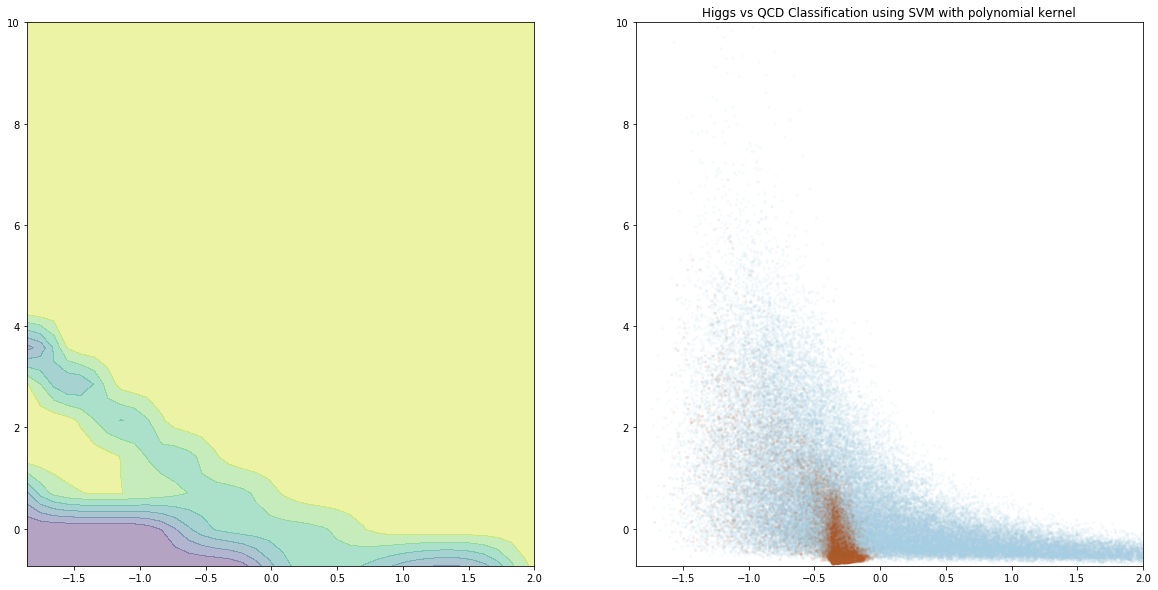

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

x_min = min(X_test_scaled[:,0])
x_max = max(X_test_scaled[:,0])
y_min = min(X_test_scaled[:,1])
y_max = max(X_test_scaled[:,1])
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100).T)
XX = np.c_[xx.ravel(), yy.ravel()]
Z = clf.predict_proba(XX)[:,0].reshape(xx.shape)

# Put the result into a color plot
ax[0].contourf(xx, yy, Z, alpha=0.4)
ax[1].scatter(X_test_scaled[:,0], X_test_scaled[:,1], c=y_test, cmap=plt.cm.Paired,
            edgecolors='k', marker='.', linewidths=0.000001, alpha=0.1)
plt.title('Higgs vs QCD Classification using SVM with polynomial kernel')
plt.axis('tight')

ax[0].set_xlim(x_min, 2)
ax[0].set_ylim(y_min, 10)
ax[1].set_xlim(x_min, 2)
ax[1].set_ylim(y_min, 10)

plt.show()

In [22]:
Higgs_scaled = scaler.transform(np.array([higgs_d.mass, higgs_d.d2]).T)
y_higgs_pred = clf.predict(Higgs_scaled)
Higgs_events = sum(y_higgs_pred)
print(f"Higgs jets: {Higgs_events:.0f}")
qcd_scaled = scaler.transform(np.array([qcd_d.mass, qcd_d.d2]).T)
y_qcd_pred = clf.predict(qcd_scaled)
QCD_events = sum(y_qcd_pred) #Number of QCD events included after classification
print(f"QCD jets:   {QCD_events:.0f}")
y_pred = np.concatenate((y_higgs_pred, y_qcd_pred), axis=0)
F1_score = f1_score(y, y_pred)
print(f"Classifier F1 score: {F1_score:.3f}")
N_higgs = evh*Higgs_events/100000
N_qcd = evq*QCD_events/100000
expected_sig = N_higgs / math.sqrt(N_qcd)
print(f'N_Higgs: {N_higgs:.0f}, N_QCD: {N_qcd:.0f}')
print(f'Expected significance: {expected_sig:.2f}')
print(f'Probability of observation given null hypothesis: {stats.norm.sf(expected_sig)}')

Higgs jets: 84466
QCD jets:   6471
Classifier F1 score: 0.885
N_Higgs: 42, N_QCD: 129
Expected significance: 3.71
Probability of observation given null hypothesis: 0.00010266383319636382


The classifier has an F1 score of around .9, and performs slightly better than our mass cut alone for selecting data to compute significance from. However, the classifier did train using two features, and our two-feature cut had a much greater performance than this classifier when it comes to maximizing expected significance.

Now to train a classifier using all 14 features,

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.7)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = preprocessing.StandardScaler().fit_transform(X)

In [24]:
clf = svm.SVC(kernel='poly', degree=3, gamma='scale', probability=True)
clf.fit(X_train_scaled,y_train)
clf.score(X_test_scaled, y_test)

0.9386571428571429

In [25]:
Higgs_scaled = scaler.transform(higgs_d)
y_higgs_pred = clf.predict(Higgs_scaled)
Higgs_events = sum(y_higgs_pred)
print(f"Higgs jets: {Higgs_events:.0f}")

qcd_scaled = scaler.transform(qcd_d)
y_qcd_pred = clf.predict(qcd_scaled)
QCD_events = sum(y_qcd_pred) #Number of QCD events included after classifier
print(f"QCD jets:   {QCD_events:.0f}")

y_pred = np.concatenate((y_higgs_pred, y_qcd_pred), axis=0)
F1_score = f1_score(y, y_pred)
print(f"Classifier F1 score: {F1_score:.3f}")
N_higgs = evh*Higgs_events/100000
N_qcd = evq*QCD_events/100000
expected_sig = N_higgs / math.sqrt(N_qcd)
print(f'N_Higgs: {N_higgs:.0f}, N_QCD: {N_qcd:.0f}')
print(f'Expected significance: {expected_sig:.2f}')
print(f'Probability of observation given null hypothesis: {stats.norm.sf(expected_sig)}')

Higgs jets: 94274
QCD jets:   6462
Classifier F1 score: 0.939
N_Higgs: 47, N_QCD: 129
Expected significance: 4.15
Probability of observation given null hypothesis: 1.689262193294585e-05



The classifier with 14 features performs slightly better than the classifier with 2 features, with an F1 score of 0.94 and an expected significance of 4 sigma.

Now, using the classifier and the cuts,

In [26]:
size = len(y)/2
higgs_new = higgs_d[y_pred[:100000] == 1]
qcd_new = qcd_d[y_pred[100000:] == 1]
higgs_mask = higgs_new.d2.between(best_cut_d2[0],best_cut_d2[1]) & higgs_new.mass.between(best_cut_mass[0], best_cut_mass[1])
qcd_mask = qcd_new.d2.between(best_cut_d2[0],best_cut_d2[1]) & qcd_new.mass.between(best_cut_mass[0], best_cut_mass[1])
N_higgs = evh*len(higgs_new.mass[higgs_mask])/size
N_qcd = evq*len(qcd_new.mass[qcd_mask])/size
expected_sig = N_higgs / math.sqrt(N_qcd)
print(f'Expected significance: {expected_sig:.2f}')
print('Higgs events: ', len(higgs_new.mass[higgs_mask]))
print('QCD events: ',len(qcd_new.mass[qcd_mask]))
one = np.ones((len(higgs_new.mass[higgs_mask]), 1))
two = np.zeros((200000-len(higgs_new.mass[higgs_mask])-len(qcd_new.mass[qcd_mask])))
three = np.ones((len(qcd_new.mass[qcd_mask]),1))
y_combined = np.concatenate([one.squeeze(),two.squeeze(),three.squeeze()])
f1 = f1_score(y, y_combined)
print(f'F1 score of classifier + data cuts: {f1:.2f}')

Expected significance: 25.82
Higgs events:  56098
QCD events:  59
F1 score of classifier + data cuts: 0.72


The classifier plus data cuts provides a massive increase in expected significance, however greatly decreases the f1 score which accounts for true negatives and false positives. The data cuts are very effective for maximizing signal to noise ratio, however the true negative rate makes it unusable for classifying experimental data.

Out of these three methods, the classifier followed by data cuts had the best performance for optimizing expected significance, at the cost of a nearly 50% true negative rate and large computational complexity. Alternatively, only using the data cuts had a marginally lower expected significance and minimal computation time. Going into the experimental data analysis, the data cut method alone will be used.

### Part 3: Experimental Data Analysis
#### 3.1: High Luminosity Data

In [27]:
high = pd.read_hdf('data_highLumi_pt_1000_1200.h5')
low = pd.read_hdf('data_lowLumi_pt_1000_1200.h5')

In [30]:
N_higgs = len(high.mass)/len(higgs_d.mass)*evh
N_qcd = len(high.mass)/len(qcd_d.mass)*evq
print(f'N_Higgs scaled: {N_higgs:.0f}')
print(f'N_QCD scaled: {N_qcd:.0f}')

N_Higgs scaled: 2
N_QCD scaled: 81


Scaling the expected number of Higgs and QCD particles from 100k events to 4k yields an expected $N_{Higgs}=2$ and $N_{QCD}=81$ without any event selection.

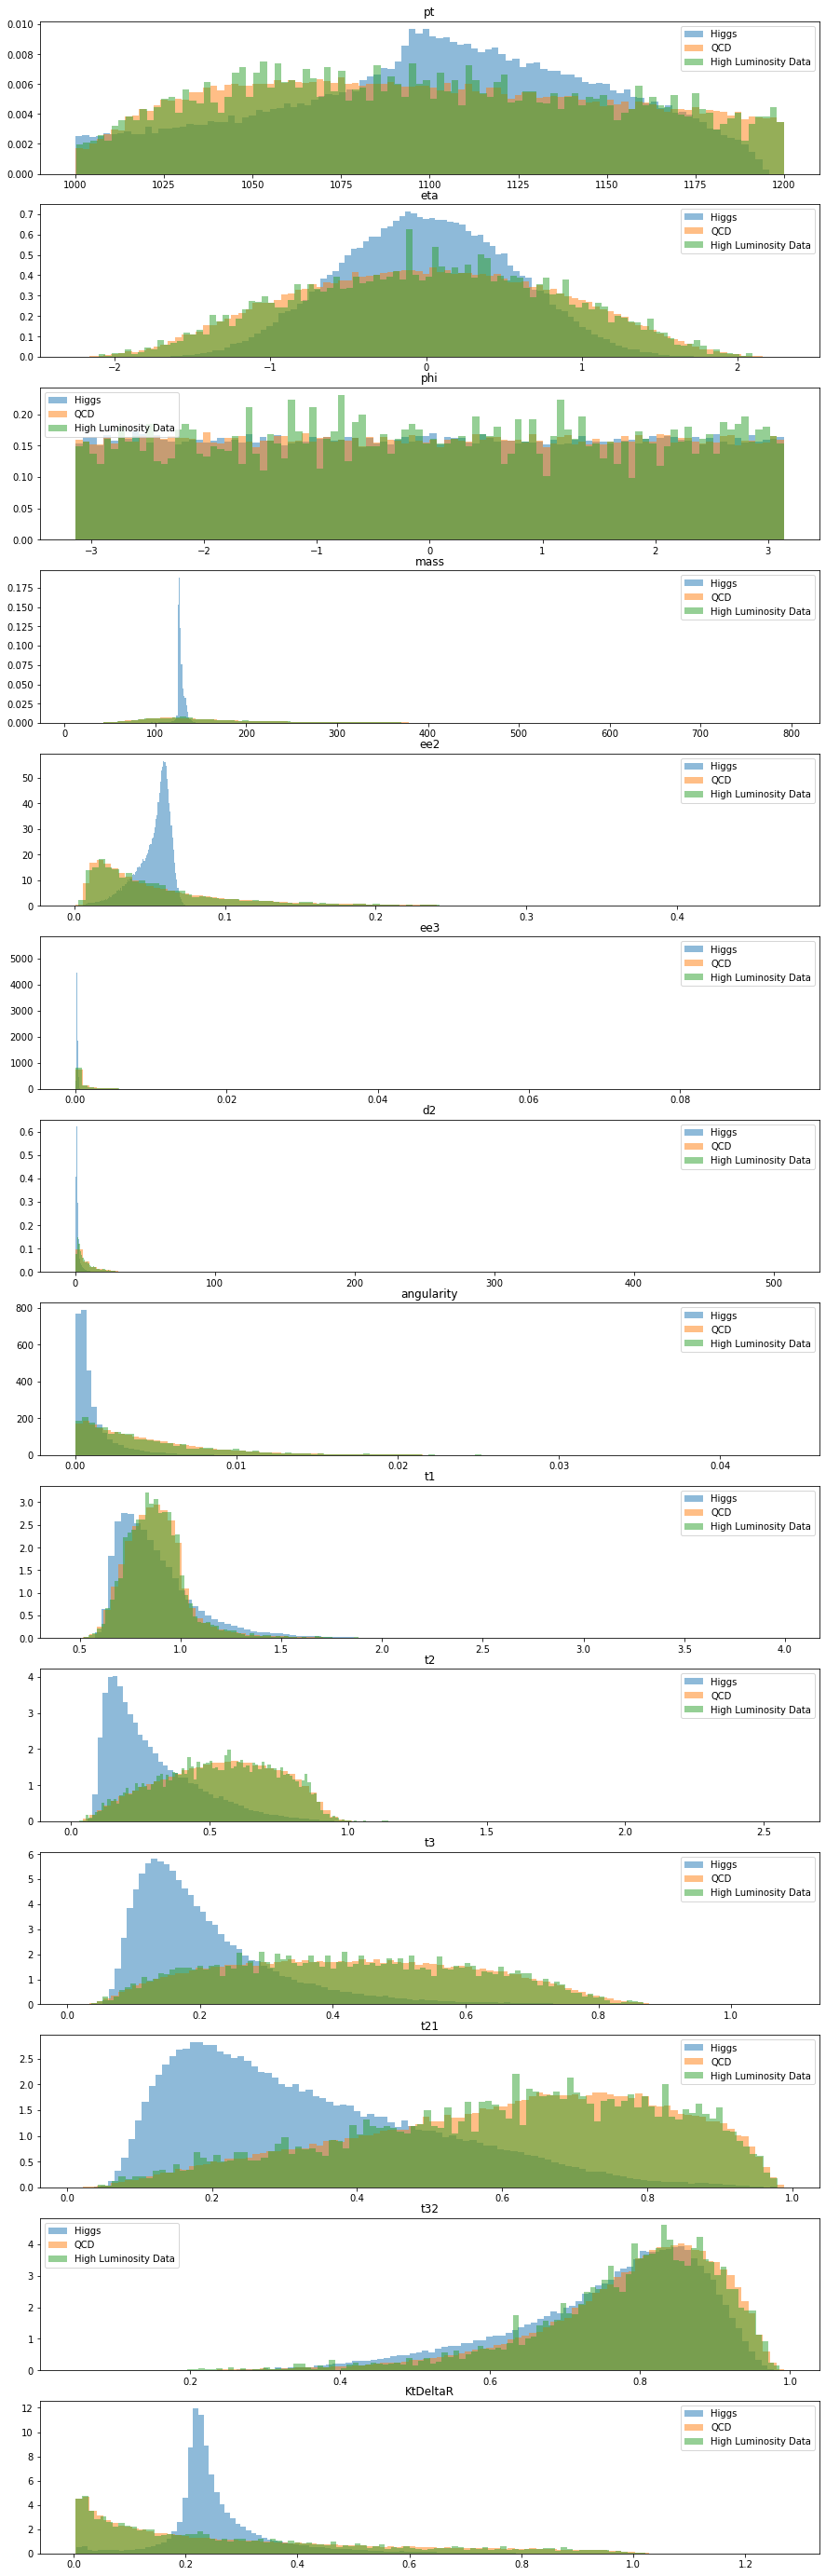

In [32]:
fig, ax_arr = plt.subplots(len(qcd_d.keys()),1, figsize=(15,50))
index = 0
for key in qcd_d.keys():
    ax_arr[index].hist(higgs_d.get(key), bins=100, density=True, alpha = 0.5, label='Higgs')
    ax_arr[index].hist(qcd_d.get(key), bins=100, density=True, alpha = 0.5, label='QCD')
    ax_arr[index].hist(high.get(key), bins=100, density=True, alpha = 0.5, label='High Luminosity Data')
    ax_arr[index].set_title(key)
    ax_arr[index].legend()
    index += 1

The above are stacked histograms of the higgs data set (light blue), the qcd data set (orange) and the experimental high luminosity data set (green). This is without any event selection.

Now using our data cut to perform our event selection

In [33]:
high_mask = high.mass.between(best_cut_mass[0],best_cut_mass[1]) & high.d2.between(best_cut_d2[0],best_cut_d2[1])
higgs_mask = higgs_d.d2.between(best_cut_d2[0],best_cut_d2[1]) & higgs_d.mass.between(best_cut_mass[0], best_cut_mass[1])
qcd_mask = qcd_d.d2.between(best_cut_d2[0],best_cut_d2[1]) & qcd_d.mass.between(best_cut_mass[0], best_cut_mass[1])

N_qcd = len(qcd_d[qcd_mask == 1])/100000*2000

high_events = len(high[high_mask == 1])

print(f'Selected experiment events: {high_events:.0f}')
print(f'N_QCD in best cut range: {N_qcd:.0f}')
obs_significance = stats.norm.isf(stats.poisson.sf(high_events, N_qcd))
print(f'Observed significance: {obs_significance:.2f}')

Selected experiment events: 67
N_QCD in best cut range: 1
Observed significance: 20.39


There were 67 observed events and 1 expected QCD particle in our experimental data after optimal event selection. This gives an observed significance of 20.4 sigma when calculated using poisson statistics based on our null hypothesis. The 20.4 sigma result is considerably less than 25.8 sigma expected significance as in the training sample but still absolutely enough to claim discovery and refute the null hypothesis that the Higgs boson does not exist.

Below, plots of the remaining data after optimal event selection.

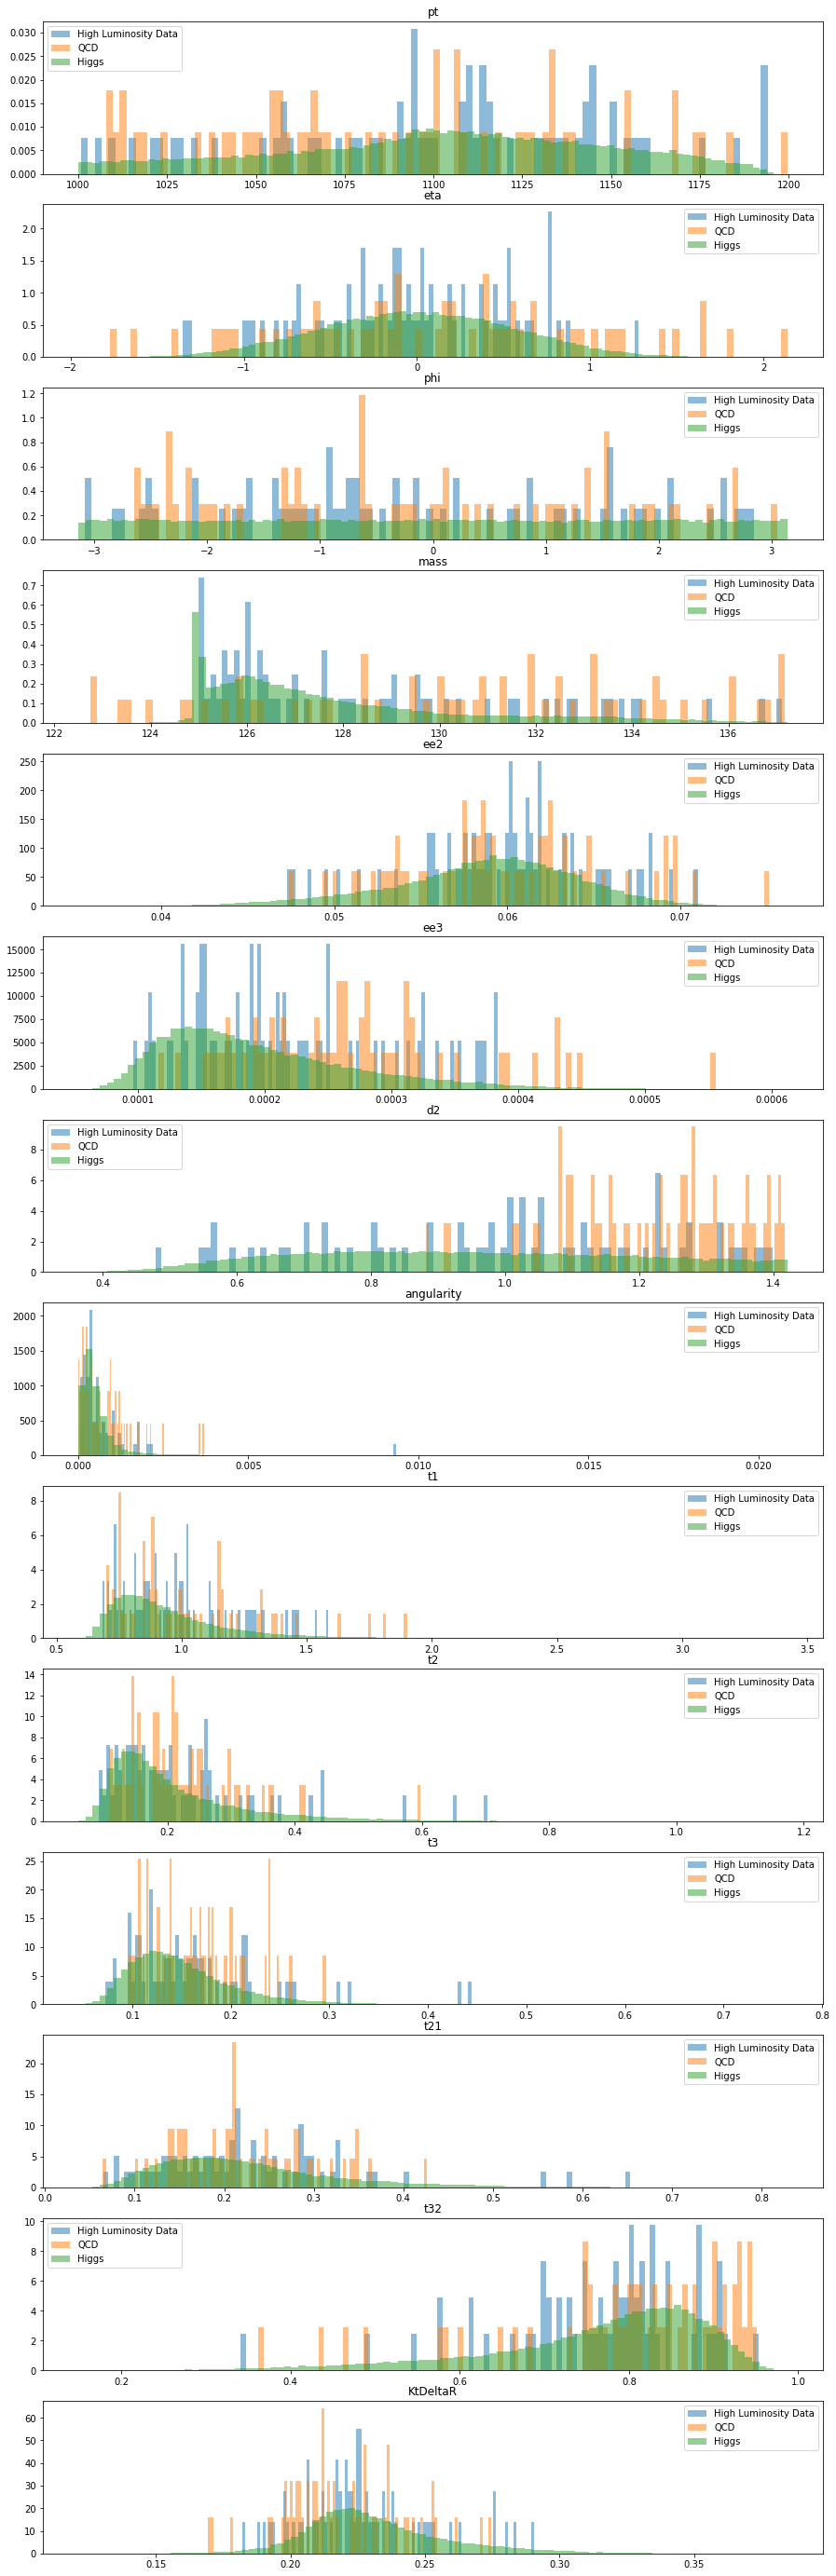

In [35]:
high_select = high[high_mask==1]
qcd_select = qcd_d[qcd_mask==1]
higgs_select = higgs_d[higgs_mask==1]

fig, ax_arr = plt.subplots(len(qcd_d.keys()),1, figsize=(15,50))
keys = qcd_d.keys()
index=0
for key in keys:
    ax_arr[index].hist(high_select.get(key), bins=100, density=True, alpha = 0.5, label='High Luminosity Data')
    ax_arr[index].hist(qcd_select.get(key), bins=100, density=True, alpha=0.5, label='QCD')
    ax_arr[index].hist(higgs_select.get(key), bins=100, density=True, alpha = 0.5, label='Higgs')
    ax_arr[index].legend()
    ax_arr[index].set_title(key)
    index = index+1

These stacked histograms represent the higgs training set in blue and the observed higgs set chosen by the classifier in orange (Optimal event selection).

#### 3.2: Low Luminosity Data

In [37]:
N_higgs = len(low.mass)/len(higgs_d.mass)*evh
N_qcd = len(low.mass)/len(qcd_d.mass)*evq
print(f'N_Higgs scaled: {N_higgs:.0f}')
print(f'N_QCD scaled: {N_qcd:.0f}')

N_Higgs scaled: 0
N_QCD scaled: 9


With the expected yield scaled down to the experiment size, we get $N_{QCD}=9$ and $N_{Higgs}=0$.

Below, plots without any event selection.

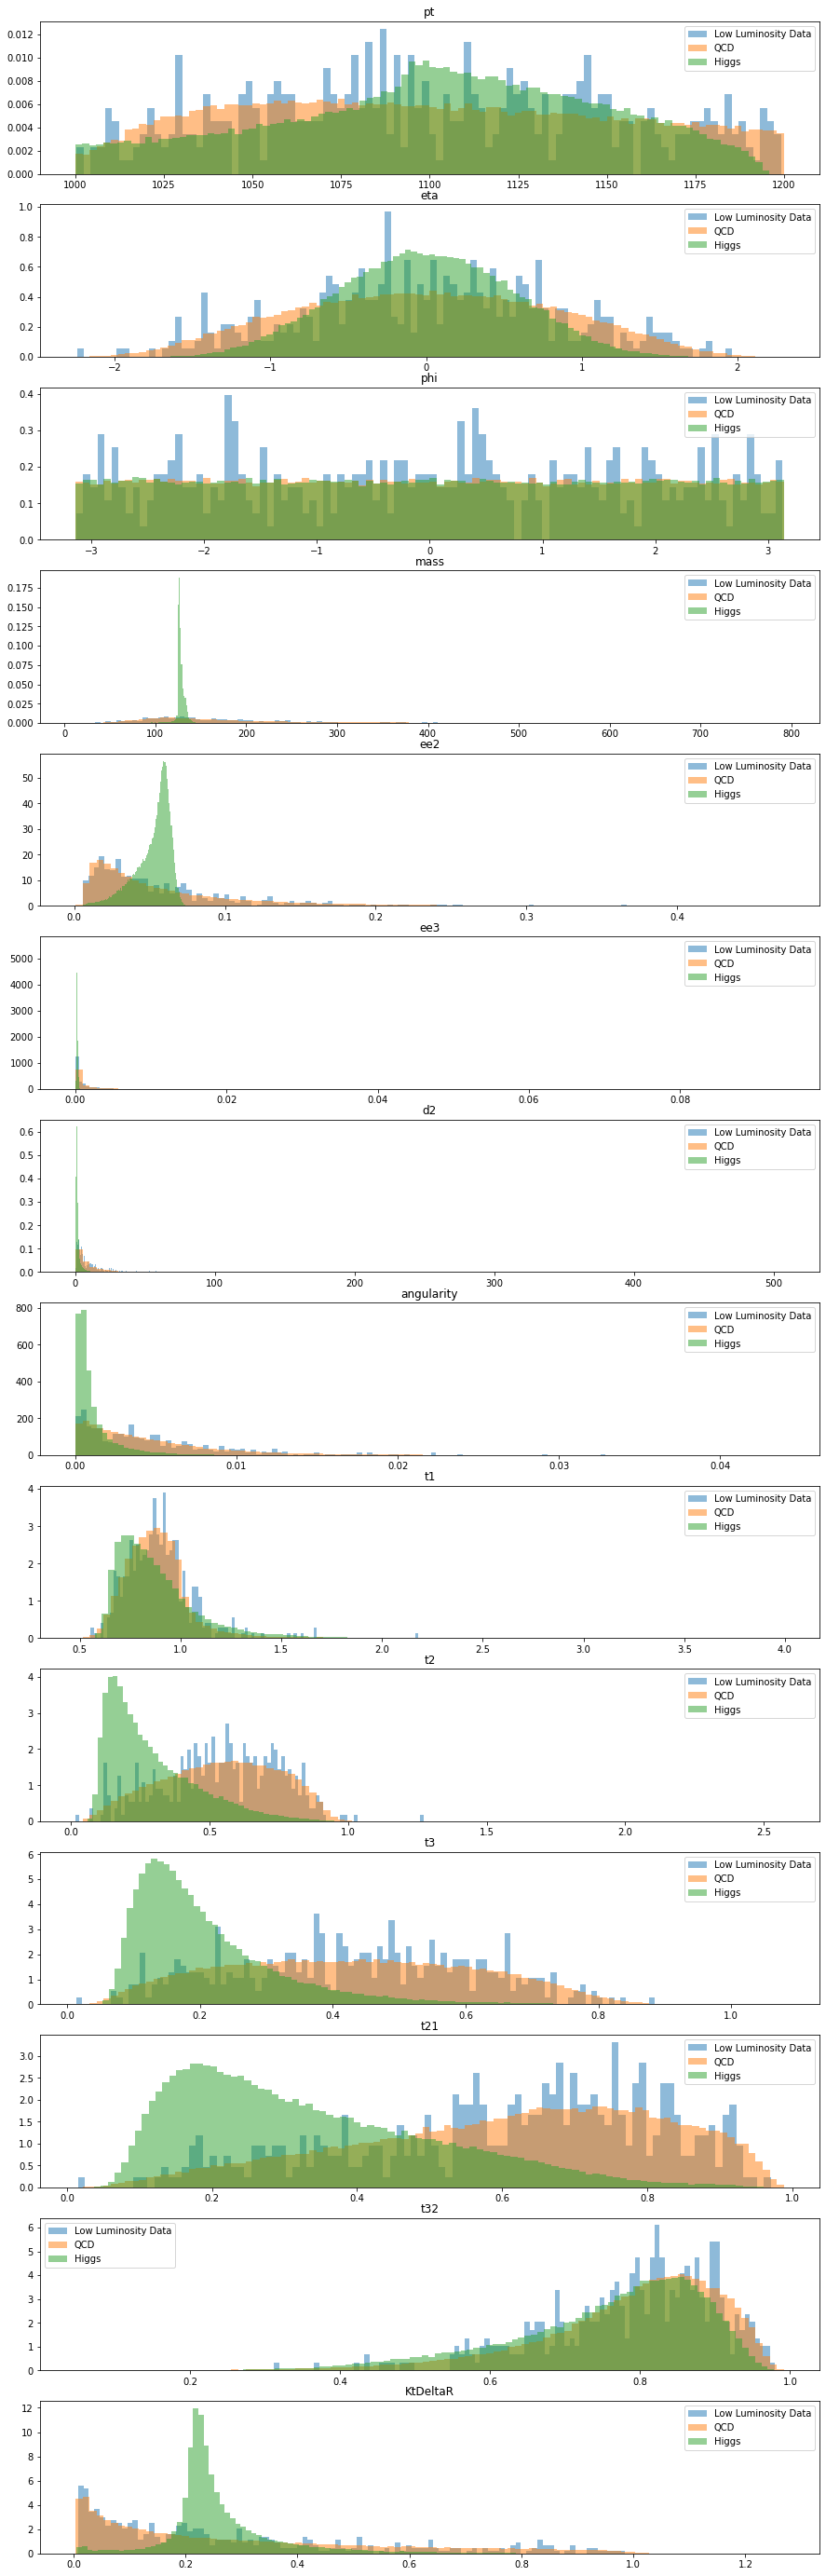

In [39]:
fig, ax_arr = plt.subplots(len(qcd_d.keys()),1, figsize=(15,50))
keys = qcd_d.keys()
index=0
for key in keys:
    ax_arr[index].hist(low.get(key), bins=100, density=True, alpha = 0.5, label='Low Luminosity Data')
    ax_arr[index].hist(qcd_d.get(key), bins=100, density=True, alpha=0.5, label='QCD')
    ax_arr[index].hist(higgs_d.get(key), bins=100, density=True, alpha = 0.5, label='Higgs')
    ax_arr[index].legend()
    ax_arr[index].set_title(key)
    index = index+1

In [44]:
low_mask = low.mass.between(best_cut_mass[0],best_cut_mass[1]) & low.d2.between(best_cut_d2[0],best_cut_d2[1])
higgs_mask = higgs_d.d2.between(best_cut_d2[0],best_cut_d2[1]) & higgs_d.mass.between(best_cut_mass[0], best_cut_mass[1])
qcd_mask = qcd_d.d2.between(best_cut_d2[0],best_cut_d2[1]) & qcd_d.mass.between(best_cut_mass[0], best_cut_mass[1])

N_qcd = len(qcd_d[qcd_mask == 1])/100000*2000
low_events = len(low[low_mask == 1])

print(f'Selected experiment events: {low_events:.0f}')
print(f'N_QCD in best cut range: {N_qcd:.0f}')
obs_significance = stats.norm.isf(stats.poisson.sf(low_events, N_qcd))
print(f'Observed significance: {obs_significance:.2f}')

Selected experiment events: 8
N_QCD in best cut range: 1
Observed significance: 4.45


Our observed significance is 4.45 sigma, which is much lower than the expected 25.8 sigma from the data cut method.

Below, a plot of the experimental data after optimal event selection.

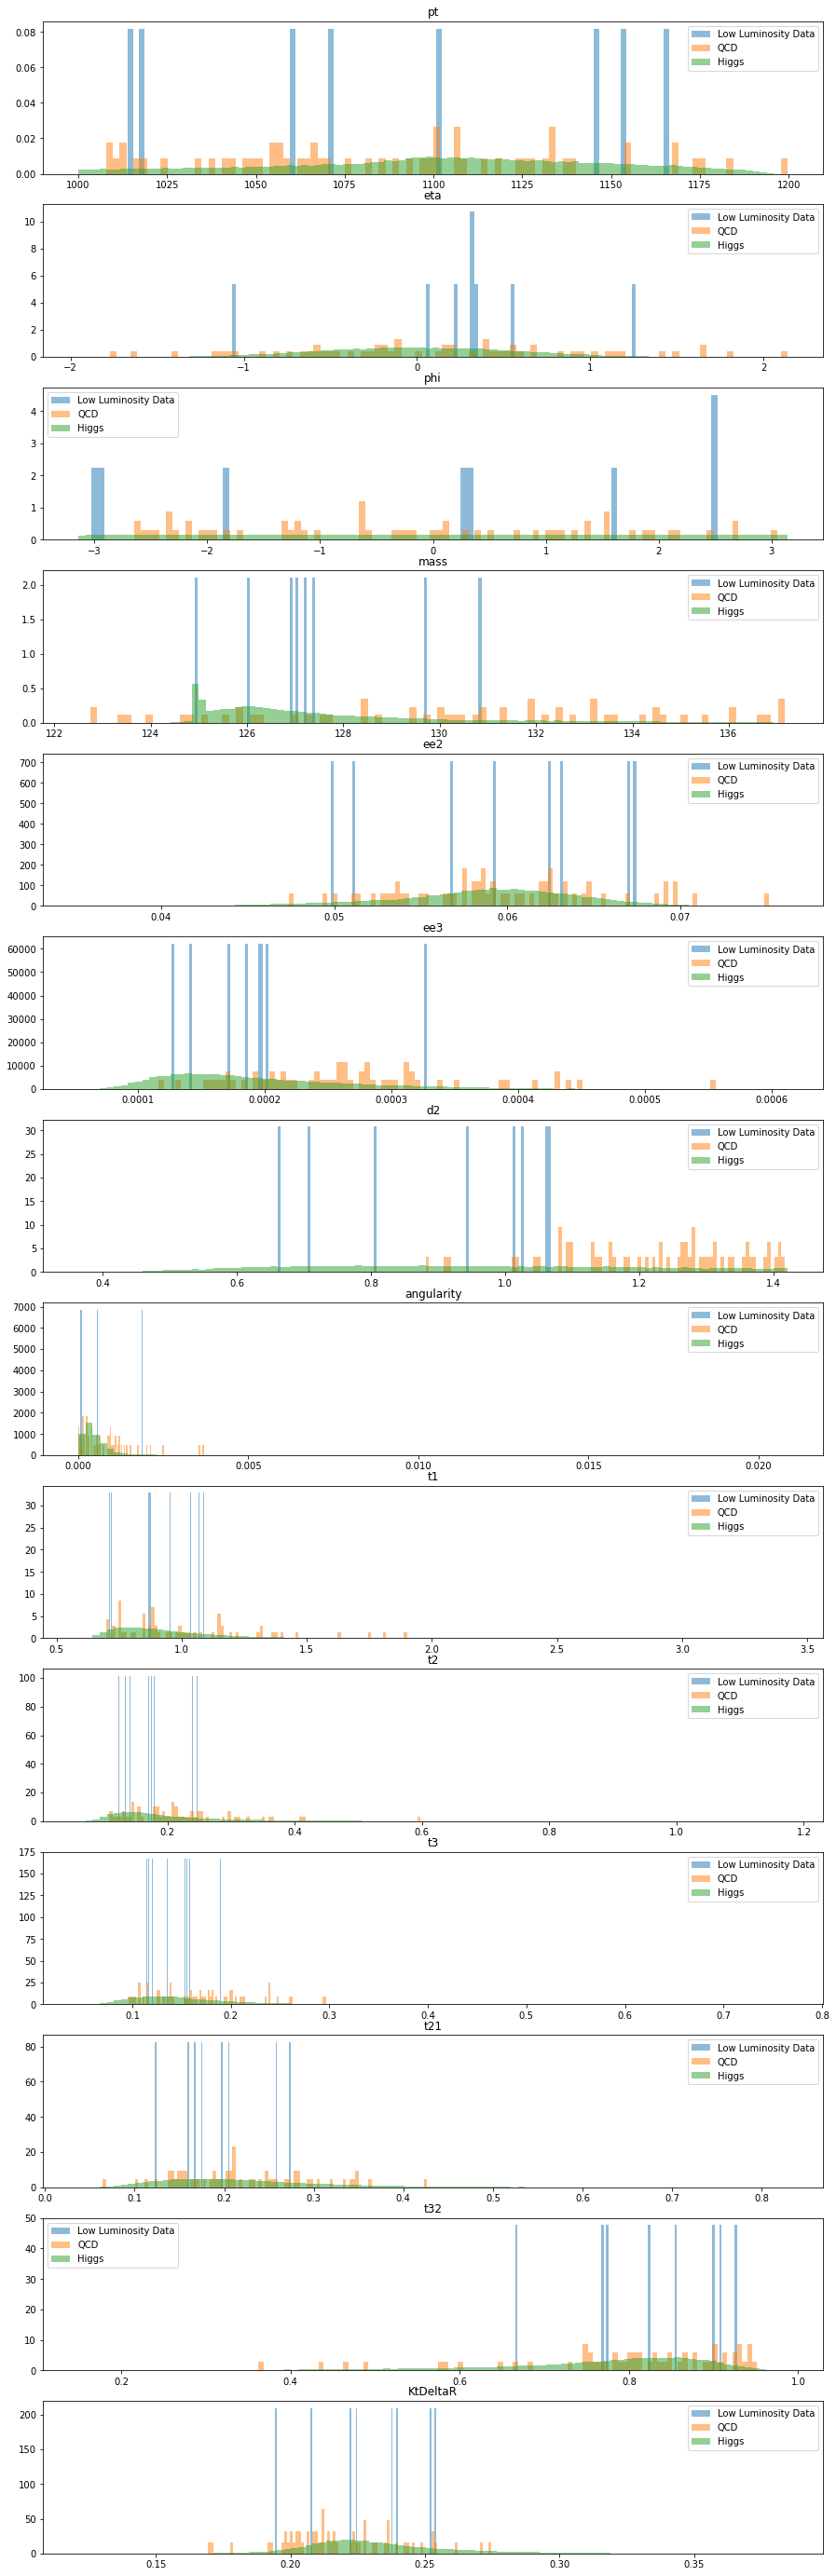

In [43]:
low_select = low[low_mask==1]
qcd_select = qcd_d[qcd_mask==1]
higgs_select = higgs_d[higgs_mask==1]

fig, ax_arr = plt.subplots(len(qcd_d.keys()),1, figsize=(15,50))
keys = qcd_di.keys()
index=0
for key in keys:
    ax_arr[index].hist(low_select.get(key), bins=100, density=True, alpha = 0.5, label='Low Luminosity Data')
    ax_arr[index].hist(qcd_select.get(key), bins=100, density=True, alpha=0.5, label='QCD')
    ax_arr[index].hist(higgs_select.get(key), bins=100, density=True, alpha = 0.5, label='Higgs')
    ax_arr[index].legend()
    ax_arr[index].set_title(key)
    index = index+1

Evaluating the expected 95% confidence interval on the low luminosity data significance,

In [47]:
higgs_mask = higgs_d.d2.between(best_cut_d2[0],best_cut_d2[1]) & higgs_d.mass.between(best_cut_mass[0], best_cut_mass[1])
qcd_mask = qcd_d.d2.between(best_cut_d2[0],best_cut_d2[1]) & qcd_d.mass.between(best_cut_mass[0], best_cut_mass[1])
N_higgs = evh*len(higgs_d.mass[higgs_mask])/size
N_qcd = evq*len(qcd_d.mass[qcd_mask])/size
expected_sig = N_higgs / math.sqrt(N_qcd)
upper_sig = (N_higgs + 2*math.sqrt(N_qcd))/math.sqrt(N_qcd)
lower_sig = (N_higgs - 2*math.sqrt(N_qcd))/math.sqrt(N_qcd)
print(f"Expected:  {expected_sig:.2f}")
print(f"Expected 95% condicence level upper limit:  {upper_sig:.2f}")
print(f"Expected 95% condicence level lower limit:  {lower_sig:.2f}")

Expected:  25.84
Expected 95% condicence level upper limit:  27.84
Expected 95% condicence level lower limit:  23.84


In [48]:
uncertainty = (N_higgs + 3*math.sqrt(N_qcd))/math.sqrt(N_qcd) - (N_higgs + 2*math.sqrt(N_qcd))/math.sqrt(N_qcd)
print(f"one sigma uncertainty of expected 95% confidence upper limit: +/-{uncertainty:.2f} sigma")

one sigma uncertainty of expected 95% confidence upper limit: +/-1.00 sigma


The 95% confidence level upper limit is ~30 sigma using our analytic formula from before, but adding the standard deviation (square root of the average for a poisson distribution) multiplied by two to $N_{Higgs}$ to reach the 95% upper bound. Using poisson statistics to calculate the expected significance comes to around 12, which is far different than our analytic formula provides for the significance after event selection. Using poisson statistics to calculate, the upper limit is around 12.6 sigma.

In [49]:
upper = stats.norm.isf(stats.poisson.sf(low_events+N_qcd+2*math.sqrt(N_qcd), N_qcd))
print('Observed 95% confidence level upper limit: ', upper)

Observed 95% confidence level upper limit:  5.726105199676746


The observed 95% confidence level upper limit for the low luminosity data is 5.3 sigma.